In [1]:
#general deps
import torch
from torch.nn.functional import soft_margin_loss
from fastai.data.transforms import get_image_files
from fastai.data.core import DataLoaders
from fastai.vision.all import *
from importlib import reload
# local deps
import model as mdl; reload(mdl)
import RP_dataset as rp


In [2]:
class ToDevice(Callback):
    "Move data to CUDA device and convert it to float"
    def __init__(self, device=None): self.device = torch.device('cpu')#ifnone(device, DEVICE)
    def before_batch(self): 
        self.learn.xb = (self.learn.xb[0][0].float(), self.learn.xb[0][1].float())
        self.learn.xb,self.learn.yb = to_device(self.xb),to_device(self.yb)
    def before_fit(self): self.model.to(self.device)

In [3]:
@delegates()
class FocalBCEWithLogitFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(FocalBCEWithLogits, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [4]:
class FocalBCEWithLogits(nn.BCEWithLogitsLoss):
    def __init__(self, gamma : int = 2, size_average=None, reduce=None, reduction: str = 'mean',
                 pos_weight: Optional[Tensor] = None) -> None:
        super(FocalBCEWithLogits, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', None)
        self.register_buffer('pos_weight', pos_weight)
        self.gamma = gamma
        
    def focal_weights(self, input: Tensor, target: Tensor):
        y, t = input.sigmoid(), target 
        return 0.5*((1-t)*y + (1-y)*t).pow(self.gamma)
    
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        weight = self.focal_weights(input, target).detach()
        return F.binary_cross_entropy_with_logits(input, target,
                                                  weight = weight,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

In [5]:
import sklearn.metrics as skm
def accuracy_(inp, targ, thresh=0.5):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check((inp > thresh)*1, targ)
    return (pred == targ).float().mean()

def Precision(axis=-1, labels=None, thresh = None,  pos_label=1, average='binary', sample_weight=None):
    "Precision for single-label classification problems"
    return skm_to_fastai(skm.precision_score, thresh = thresh, axis=axis,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight)
def F1Score(axis=-1, labels=None, thresh = None,pos_label=1, average='binary', sample_weight=None):
    "F1 score for single-label classification problems"
    return skm_to_fastai(skm.f1_score, axis=axis,thresh = thresh,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight)

def Recall(axis=-1, labels=None, thresh = None, pos_label=1, average='binary', sample_weight=None):
    "Recall for single-label classification problems"
    return skm_to_fastai(skm.recall_score, axis=axis, thresh = thresh,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight)

In [6]:
# Training set
trainset = rp.RP_Dataset( subjects = [1], sampling_params= (1,90), wind_len = 15 , fin = 662)#en Sec

sampler = rp.RPSampler(trainset, batch_size = 64, size = 640,  weights = [0.5, 0.8])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, 
                                     num_workers=0,sampler = sampler, collate_fn= rp.ssl_collate)
# Validation set
val_generator = rp.RP_Dataset( subjects = [1], sampling_params= (1,60), wind_len = 15 , debut = 662)
val_sampler =  rp.RPSampler(val_generator, batch_size = 30,size = 90,  weights = [0.5]*2)

valset = torch.utils.data.Subset(val_generator, indices= list(val_sampler))
val_loader = torch.utils.data.DataLoader(valset, batch_size=30, 
                                     num_workers=0, collate_fn=rp.ssl_collate)


In [7]:
#model
model = mdl.SiameseModel(hidden_dim = 32*10,n_classes = 2, voxels = 97)
#model = model.to(torch.float)
# loss_fn 
loss_fn = CrossEntropyLossFlat()# FocalBCEWithLogitFlat( )# BCEWithLogitsLossFlat() #FocalBCEWithLogitFlat( ) #soft_margin_loss
# fastai learner
dls = DataLoaders(train_loader,val_loader) # a validation set need to be defined
learn = Learner(dls, model, loss_func=loss_fn, opt_func=Adam, metrics=[accuracy, F1Score(), Precision(), Recall()], 
                cbs = [ToDevice, SaveModelCallback( monitor='f1_score', fname='model_')])

In [8]:
learn.save('model_')

Path('models/model_.pth')

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=1.5848931980144698e-06)

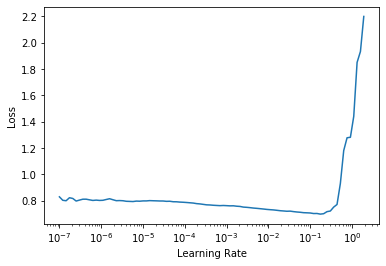

In [9]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit(6, 3e-04)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.702350,0.696778,0.544444,0.643478,0.552239,0.770833,01:00
1,0.684018,0.693072,0.588889,0.699187,0.573333,0.895833,00:54
2,0.682759,0.689897,0.533333,0.637931,0.544118,0.770833,00:59
3,0.677311,0.687352,0.566667,0.692913,0.556962,0.916667,00:55
4,0.670900,0.681962,0.555556,0.687500,0.550000,0.916667,00:56


Better model found at epoch 0 with f1_score value: 0.6434782608695653.
Better model found at epoch 1 with f1_score value: 0.6991869918699187.


In [38]:
learn.fit_one_cycle(5, 0.6e-07)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.777448,0.698867,0.500000,0.594595,0.523810,0.687500,00:40
1,0.747036,0.697838,0.466667,0.609756,0.500000,0.781250,00:38
2,0.760056,0.700616,0.500000,0.642857,0.519231,0.843750,00:39
3,0.775433,0.704144,0.500000,0.651163,0.518519,0.875000,00:41
4,0.765414,0.704800,0.533333,0.674419,0.537037,0.906250,00:37


Better model found at epoch 0 with f1_score value: 0.5945945945945946.
Better model found at epoch 1 with f1_score value: 0.6097560975609756.
Better model found at epoch 2 with f1_score value: 0.6428571428571429.
Better model found at epoch 3 with f1_score value: 0.6511627906976744.
Better model found at epoch 4 with f1_score value: 0.6744186046511628.


In [71]:
learn.fit_one_cycle(5, 0.6e-07)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.743244,0.706267,0.516667,0.666667,0.527273,0.906250,00:39
1,0.751785,0.705483,0.516667,0.666667,0.527273,0.906250,00:41
2,0.753479,0.706007,0.500000,0.651163,0.518519,0.875000,00:40
3,0.750572,0.696517,0.516667,0.658824,0.528302,0.875000,00:39
4,0.750441,0.690416,0.533333,0.666667,0.538462,0.875000,00:39


Better model found at epoch 0 with f1_score value: 0.6666666666666665.
Better model found at epoch 4 with f1_score value: 0.6666666666666667.


In [9]:
dataset = rp.RP_Dataset( subjects = [1], sampling_params= (20,30), wind_len = 15 )
X = torch.from_numpy(dataset.audio).unfold(-1, dataset.w*dataset.sr, int(1.486*dataset.sr))
AudioData = torch.utils.data.TensorDataset(X)
Audiosampler = torch.utils.data.SequentialSampler(AudioData)
Audioloader = torch.utils.data.DataLoader(AudioData, sampler = Audiosampler,  batch_size= 2)

In [10]:
## SSL audio encoder
model = learn.model#.to(torch.device("cuda"))
model.eval()
Audio_extractor = nn.Sequential( model.audio, nn.Flatten())
with torch.no_grad():
    embeddings = [Audio_extractor(audio[0]).numpy() for audio in Audioloader]
fv = np.vstack(embeddings); fv.shape

(946, 320)

In [17]:
#fv = np.load(rp.FMRIDIR+'/sub_1.npy')
middle = int(fv.shape[0]/2)
y = np.load('data/fmri/raw/fmri_97voxels.npz', allow_pickle =True)['X']
y_train = y[:middle] 
y_test = y[middle:]

In [18]:
X_train = (fv[:middle])
X_test = (fv[middle:])

In [20]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
clf = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))
clf.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=0))

In [25]:
predictions = clf.predict(X_test)
scores = r2_score(y_test, predictions, multioutput='raw_values')
#scores[scores < 0] = 0;
scores

array([ 0.07593198,  0.05586931, -0.05184485,  0.15926299, -0.01625926,
        0.0477893 ,  0.03651086,  0.08054457,  0.11153366,  0.16544547,
        0.04476778,  0.07010355,  0.09483618,  0.00400971,  0.14733563,
        0.1593623 ,  0.08662763,  0.0374167 ,  0.13701507,  0.09456718,
       -0.03489638, -0.08458128, -0.02535507,  0.13721709,  0.14669997,
        0.05102374,  0.01490289,  0.09118962,  0.05556091,  0.044879  ,
        0.03781872,  0.00770876,  0.10180508,  0.09908221,  0.09132212,
        0.11845733,  0.01054471, -0.04379596, -0.10110217, -0.00081658,
       -0.01290718,  0.04319289,  0.04351495,  0.07198017,  0.05816141,
        0.02450486,  0.06925222,  0.0311666 , -0.08449721, -0.02728814,
        0.03168523,  0.09939973,  0.02076418,  0.09824388,  0.15583612,
        0.05736454,  0.04196868,  0.07724518,  0.08998976,  0.07893431,
        0.07176828,  0.13880206,  0.06799521,  0.06568973,  0.06644305,
       -0.024534  ,  0.15167074,  0.09397835, -0.09107809,  0.02

In [31]:
print(f"R2 scores in {(scores>0.1).mean():.2f}% of regions higher than {0.01}")

R2 scores in 0.20% of regions higher than 0.01


In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
estimator = Ridge(alpha=100) # Alpha value has been explored before
estimator.fit(y_train,y_train)
predictions = estimator.predict(y_test)
scores = r2_score(y_test, predictions, multioutput='raw_values')
#scores[scores < 0] = 0;
scores

array([-1.08657267e-02, -3.04873819e-06, -1.99546743e-03, -7.97596040e-03,
       -2.95578469e-04, -2.64732934e-04, -1.04435436e-03, -9.07161240e-03,
       -9.63237153e-03, -2.12242168e-02, -7.22458383e-03, -8.86375465e-03,
       -2.96708732e-02, -3.94775669e-02, -2.78856475e-02, -2.69149824e-02,
       -2.40163448e-02, -4.22268047e-02, -3.93426624e-02, -1.80882564e-02,
       -2.70325779e-02, -1.29372190e-02, -1.53491970e-02, -5.26548746e-02,
       -3.67195153e-02, -1.51766300e-03, -3.96925247e-03, -2.44949029e-02,
       -1.14568054e-02, -1.81706441e-02, -5.67513166e-03, -1.57140181e-04,
       -1.94256056e-02, -3.95299118e-03, -1.10118927e-02, -3.75188843e-02,
       -1.59097810e-02, -9.81549908e-03, -1.99214109e-03, -1.52581549e-02,
       -4.54622460e-02, -3.58609803e-02, -2.36629211e-03, -2.78779499e-04,
       -2.40070151e-02, -1.41815647e-02, -2.07605591e-02, -2.07704480e-02,
       -2.52210221e-03, -1.24632374e-02, -9.28542863e-04, -1.59262678e-02,
       -1.61089479e-02, -

In [21]:
print(f"R2 scores in {(scores>0.1).mean():.2f}% of regions higher than {0.1}")

R2 scores in 0.00% of regions higher than 0.1


In [144]:
learn.fit_one_cycle(5, 7e-04)

epoch,train_loss,valid_loss,accuracy_,f1_score,precision_score,recall_score,time
0,0.105073,0.088751,0.450000,0.744681,0.593220,1.000000,00:38
1,0.103664,0.089342,0.433333,0.707317,0.617021,0.828571,00:40
2,0.098960,0.091515,0.416667,0.712644,0.596154,0.885714,00:38
3,0.098081,0.093063,0.433333,0.719101,0.592593,0.914286,00:39
4,0.096804,0.092860,0.416667,0.704545,0.584906,0.885714,00:38


Better model found at epoch 0 with f1_score value: 0.7446808510638298.


In [8]:
learn.load('model_')
learn.validate()

Better model found at epoch 0 with f1_score value: 0.6.


(#5) [0.7074955105781555,0.5833333134651184,0.7252747252747253,0.6,0.9166666666666666]